# Relational Games: Row Match [`dev`]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os; os.environ['TF_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

import data_utils
import sys; sys.path.append('../../')
import utils

2023-09-02 14:20:18.907780: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-02 14:20:18.962566: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-02 14:20:20.644500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Set Up

In [10]:
import argparse
args = argparse.Namespace()
args.task = '1task_match_patt'
args.train_split = 'pentos'
args.test_split_size = 5000
args.n_epochs = 100
args.early_stopping = True
args.batch_size = 256
args.val_size = 1000
args.test_size = 5000

### Load Data

In [11]:
# utils.print_section('LOADING DATA')
data_path = '../../data/relational_games'

dataset_specs = np.load(f'{data_path}/dataset_specs.npy', allow_pickle=True).item()

task_datasets = data_utils.load_task_datasets(args.task, data_path, data_format='tfrecord', ds_specs=dataset_specs)

train_split_ds = task_datasets[args.train_split]
# train_split_ds = data_utils.load_ds_from_npz(filename)

train_ds, val_ds, test_ds = utils.split_ds(train_split_ds, val_size=args.val_size, test_size=args.test_size)
del train_split_ds

batch_size = args.batch_size
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

eval_datasets = {split: ds.take(args.test_split_size).batch(batch_size) for split, ds in task_datasets.items() if split != args.train_split}


In [12]:
len(test_ds) * batch_size

5120

In [13]:
len(train_ds)

244000

### Training Set up

In [14]:
#region training setup
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
create_opt = lambda: tf.keras.optimizers.Adam()
metrics = [
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        # tf.keras.metrics.Precision(class_id=1, name='precision'),
        # tf.keras.metrics.Recall(class_id=1, name='recall'),
        # tf.keras.metrics.F1Score(average='weighted', name='f1'),
        tf.keras.metrics.AUC(curve='ROC', multi_label=True, name='auc')
        ]

from tqdm.keras import TqdmCallback
from tqdm import tqdm
def create_callbacks(data_size=None, batch_size=None):
    callbacks = [
        TqdmCallback(data_size=data_size, batch_size=batch_size, tqdm_class=tqdm),
        # wandb.keras.WandbMetricsLogger(log_freq='epoch')
    ]

    if args.early_stopping:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, start_from_epoch=20))

    return callbacks

fit_kwargs = dict(epochs=args.n_epochs)
batch_size = args.batch_size
#endregion


## CoRelNet

In [16]:
from relational_neural_networks.multi_head_relation import MultiHeadRelation
from relational_neural_networks.relational_graphlet_convolution import RelationalGraphletConvolution
from relational_neural_networks.grouping_layers import TemporalGrouping, FeatureGrouping
from cnn_embedder import CNNEmbedder

In [26]:
# global parameters
cnn_embedder_kwargs = dict(n_f=(16,16), s_f=(3,3), pool_size=2)

# RelConvNet
corelnet_mhr_kwargs = dict(rel_dim=1, proj_dim=4, symmetric=True)
cnn_embedder_kwargs = dict(n_f=(16,16), s_f=(3,3), pool_size=2)

# def create_relconvnet():
mhr = MultiHeadRelation(**corelnet_mhr_kwargs, name='mhr')
cnn_embedder = CNNEmbedder(**cnn_embedder_kwargs)

model = tf.keras.Sequential(
    [
        cnn_embedder,
        tf.keras.layers.UnitNormalization(),
        mhr,
        tf.keras.layers.Softmax(axis=-1, name='softmax'),
        tf.keras.layers.Flatten(name='flatten'),
        tf.keras.layers.Dense(32, activation='relu', name='hidden_dense1'),
        tf.keras.layers.Dense(2, name='output')],
    name='rel_conv_net')

    # return model

In [27]:
opt = tf.keras.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(0.01, 100, 0.96))
# opt = tf.keras.optimizers.SGD(0.001)
model.compile(loss=loss, optimizer=opt, metrics=metrics) # compile
model.build(input_shape=(None, *train_ds.element_spec[0].shape)) # build
print(model.summary())

Model: "rel_conv_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_embedder_3 (CNNEmbedde  (None, 9, 16)             2768      
 r)                                                              
                                                                 
 unit_normalization (UnitNo  (None, 9, 16)             0         
 rmalization)                                                    
                                                                 
 mhr (MultiHeadRelation)     (None, 9, 9, 1)           68        
                                                                 
 softmax (Softmax)           (None, 9, 9, 1)           0         
                                                                 
 flatten (Flatten)           (None, 81)                0         
                                                                 
 hidden_dense1 (Dense)       (None, 32)               

In [28]:
train_size = -1 # 5_000
batch_size = 512

shuffle_buffer_size = train_size
train_ds_sample = train_ds.take(train_size).batch(batch_size)
history = model.fit(
    train_ds_sample, validation_data=val_ds, verbose=1, epochs=50)

Epoch 1/50


2023-09-02 14:50:55.003401: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


477/477 [==============================] - 151s 294ms/step - loss: 0.6985 - acc: 0.5001 - auc: 0.5009 - val_loss: 0.6923 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 2/50
477/477 [==============================] - 138s 277ms/step - loss: 0.6933 - acc: 0.5000 - auc: 0.4997 - val_loss: 0.6931 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 3/50
477/477 [==============================] - 147s 296ms/step - loss: 0.6932 - acc: 0.5000 - auc: 0.4994 - val_loss: 0.6930 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 4/50
477/477 [==============================] - 140s 282ms/step - loss: 0.6932 - acc: 0.5000 - auc: 0.4990 - val_loss: 0.6926 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 5/50
477/477 [==============================] - 132s 265ms/step - loss: 0.6932 - acc: 0.5000 - auc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 6/50
477/477 [==============================] - 134s 270ms/step - loss: 0.6932 - acc: 0.5000 - auc: 0.5006 - val_loss: 0.6932 - val_acc: 0.5000 - val_auc: 0.5000
Epo

KeyboardInterrupt: 

In [ ]:
model.evaluate(test_ds)

20/20 [==============================] - 8s 81ms/step - loss: 0.0092 - acc: 0.6556 - precision: 0.6151 - recall: 0.6810 - f1: 0.9982 - auc: 0.6586


[0.009209304116666317,
 0.6556000113487244,
 0.6150537729263306,
 0.6809523701667786,
 0.9982000589370728,
 0.6585724353790283]

In [ ]:
utils.plot_history(history, plot_attrs=('loss','acc'));

In [ ]:
model.evaluate(val_ds)

## Relational Convolution

In [32]:
from relational_neural_networks.multi_head_relation import MultiHeadRelation
from relational_neural_networks.relational_graphlet_convolution import RelationalGraphletConvolution
from relational_neural_networks.grouping_layers import TemporalGrouping, FeatureGrouping
from cnn_embedder import CNNEmbedder

In [35]:
import itertools
# groups = [group for group in itertools.permutations(range(9), r=3) if all(x in (0,1,2,6,7,8) for x in group)]
groups = [(0,1,2), (6,7,8)]

In [48]:
# RelConvNet
relconv_mhr_kwargs = dict(rel_dim=8, proj_dim=4, symmetric=True)
relconv_kwargs = dict(n_filters=32, graphlet_size=3,
        symmetric_inner_prod=False)
cnn_embedder_kwargs = dict(n_f=(16,16), s_f=(3,3), pool_size=2)

# def create_relconvnet():
mhr1 = MultiHeadRelation(**relconv_mhr_kwargs, name='mhr1')
mhr2 = MultiHeadRelation(**relconv_mhr_kwargs, name='mhr2')

rel_conv1 = RelationalGraphletConvolution(
    **relconv_kwargs, groups=groups, name='rgc1')
rel_conv2 = RelationalGraphletConvolution(
    **relconv_kwargs, groups='combinations', name='rgc2')

# feature_grouping = FeatureGrouping(num_groups=32, use_pos=True,
#     mlp_shape=(32, 32), mlp_activations='relu', name='feature_grouping')
temporal_grouper1 = TemporalGrouping(num_groups=16, weight_initializer='glorot_uniform', name='temporal_grouper1')
temporal_grouper2 = TemporalGrouping(num_groups=4, weight_initializer='glorot_uniform', name='temporal_grouper2')

cnn_embedder = CNNEmbedder(**cnn_embedder_kwargs)
l2_normalizer = tf.keras.layers.UnitNormalization(name='l2_normalization')

inputs = tf.keras.layers.Input(shape=train_ds.element_spec[0].shape)
embedded_objects = cnn_embedder(inputs)
embedded_objects = l2_normalizer(embedded_objects)
rel_tensor = mhr1(embedded_objects)
# g = feature_grouping(embedded_objects)
g = temporal_grouper1(embedded_objects)
convolution = rel_conv1(rel_tensor, g)
# rel_tensor = mhr2(convolution)
# g = temporal_grouper2(convolution)
# convolution = rel_conv2(rel_tensor, g)
# convolution = rel_conv(rel_tensor)

x = tf.keras.layers.Flatten(name='flatten')(convolution)
x = tf.keras.layers.Dense(64, activation='relu', name='hidden_dense1')(x)
x = tf.keras.layers.Dense(2, name='output')(x)
outputs = x

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='relconvent')

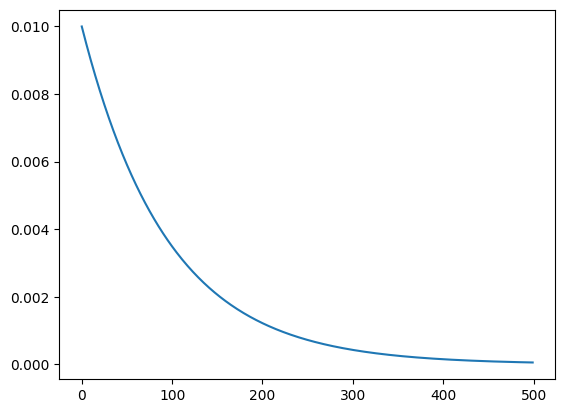

In [47]:
plt.plot(np.arange(50*10), 0.01*0.9**(np.arange(50*10)/10))

In [51]:
# opt = tf.keras.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(0.01, 10, 0.9)) #TODO: here
opt = tf.keras.optimizers.Adam(0.001) #TODO: here
# opt = tf.keras.optimizers.SGD(0.001)
model.compile(loss=loss, optimizer=opt, metrics=metrics) # compile
model.build(input_shape=(None, *train_ds.element_spec[0].shape)) # build
print(model.summary())

Model: "relconvent"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 9, 12, 12, 3)]       0         []                            
                                                                                                  
 cnn_embedder_5 (CNNEmbedde  (None, 9, 16)                2768      ['input_2[0][0]']             
 r)                                                                                               
                                                                                                  
 l2_normalization (UnitNorm  (None, 9, 16)                0         ['cnn_embedder_5[0][0]']      
 alization)                                                                                       
                                                                                         

In [52]:
train_size = -1 # 5_000
batch_size = 512

shuffle_buffer_size = train_size
train_ds_sample = train_ds.take(train_size).batch(batch_size)
history = model.fit(
    train_ds_sample, validation_data=val_ds, verbose=1, epochs=50)

Epoch 1/50
477/477 [==============================] - 160s 312ms/step - loss: 0.6925 - acc: 0.5000 - auc: 0.5012 - val_loss: 0.6832 - val_acc: 0.5000 - val_auc: 0.5389
Epoch 2/50
477/477 [==============================] - 149s 300ms/step - loss: 0.4385 - acc: 0.5786 - auc: 0.6324 - val_loss: 0.2847 - val_acc: 0.6450 - val_auc: 0.6906
Epoch 3/50
477/477 [==============================] - 150s 304ms/step - loss: 0.2178 - acc: 0.6579 - auc: 0.6876 - val_loss: 0.1445 - val_acc: 0.6640 - val_auc: 0.6795
Epoch 4/50
477/477 [==============================] - 149s 302ms/step - loss: 0.1158 - acc: 0.6672 - auc: 0.6806 - val_loss: 0.0758 - val_acc: 0.6720 - val_auc: 0.6845
Epoch 5/50
187/477 [==========>...................] - ETA: 1:21 - loss: 0.0763 - acc: 0.6788 - auc: 0.6885

In [ ]:
model.evaluate(test_ds)

20/20 [==============================] - 8s 81ms/step - loss: 0.0092 - acc: 0.6556 - precision: 0.6151 - recall: 0.6810 - f1: 0.9982 - auc: 0.6586


[0.009209304116666317,
 0.6556000113487244,
 0.6150537729263306,
 0.6809523701667786,
 0.9982000589370728,
 0.6585724353790283]

In [ ]:
utils.plot_history(history, plot_attrs=('loss','acc'));

In [ ]:
model.evaluate(val_ds)

In [ ]:
preds = model.predict(val_ds)

In [ ]:
preds = np.argmax(preds, axis=1)

In [ ]:
preds

In [ ]:
y_val = np.array(list(val_ds.map(lambda x,y: y[1]).unbatch().as_numpy_iterator()))

In [ ]:
y_val.astype(int)

In [ ]:
np.mean([pred==y for pred,y in zip(preds,y_val)])

*NOTES:*
- need intermediate layer before final output
- todo: check if grouping layer helps
- todo: experiment w given good discrete groups